# Deep Learning Challenge - Training
## Michelle Rohrer

Dieses Notebook enthält alle Trainings.

### Pakete laden

In [1]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='pydantic')

# Dann der Rest Ihrer Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import wandb
from dotenv import load_dotenv
import pickle
import gc

import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import multiprocessing

from src.plots import (
    plot_training_curves,
    plot_hyperparameter_comparison,
    plot_hyperparameter_performance_summary,
    plot_experiment_comparison,
    plot_model_complexity_analysis,
    plot_training_curves_comparison
)
from src.model import BaselineCNN, FlexibleCNN, create_deeper_model, create_wider_model, create_model_with_fc_width
from src.test_train import (
    train_model,
    hyperparameter_tuning_with_wandb
)
from src.evaluation import (
    cross_validation_training
)
from src.experiments import run_hyperparameter_experiment, save_experiment_results
from setup_config import get_device, get_optimal_num_workers, should_use_pin_memory

load_dotenv()
wandb_key = os.getenv('KEY')

if wandb_key:
    print("WanDB Key erfolgreich geladen")
else:
    print("WanDB Key nicht gefunden")


WanDB Key erfolgreich geladen


### Daten laden


In [2]:
base_path = "data"
train_dir = os.path.join(base_path, "train")
test_dir  = os.path.join(base_path, "test")

img_size = 48
batch_size = 32 

# Transformationen
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

# train laden
full_train_dataset = datasets.ImageFolder(
    root=train_dir,
    transform=transform
)

# 80/20 Split für Training/Validation
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_train_dataset, 
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# Test-Dataset
test_dataset = datasets.ImageFolder(
    root=test_dir,
    transform=transform
)

# DataLoader erstellen mit Multi-Core Optimierung
optimal_workers = min(4, get_optimal_num_workers())
print(f"Verwende {optimal_workers} Worker für DataLoader (von {multiprocessing.cpu_count()} Cores)")
print(f"Batch-Größe: {batch_size} (reduziert für Speicher-Optimierung)")

# pin_memory nur für CUDA aktivieren (nicht für MPS oder CPU)

use_pin_memory = should_use_pin_memory()
if use_pin_memory:
    print("pin_memory aktiviert (CUDA erkannt)")
else:
    print("pin_memory deaktiviert (MPS oder CPU - keine Warnung)")

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=optimal_workers,
    pin_memory=use_pin_memory  # Nur bei CUDA aktivieren
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=optimal_workers,
    pin_memory=use_pin_memory
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=optimal_workers,
    pin_memory=use_pin_memory
)

print(f"Klassen: {full_train_dataset.class_to_idx}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Verwende 4 Worker für DataLoader (von 10 Cores)
Batch-Größe: 32 (reduziert für Speicher-Optimierung)
pin_memory deaktiviert (MPS oder CPU - keine Warnung)
Klassen: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Training samples: 22967
Validation samples: 5742
Test samples: 7178


### Training des Basismodells

**Zweck:** Automatisches Tracking aller Experimente für bessere Reproduzierbarkeit und Analyse.

**Was wird getrackt:**
- **Hyperparameter:** Lernrate, Batch-Größe, Optimizer-Einstellungen
- **Metriken:** Training/Validation Loss und Accuracy pro Epoche
- **Test-Metriken:** Accuracy, Precision, Recall, F1-Score, Top-K Accuracy


In [3]:
# wandb Setup
# wandb API Key aus .env laden
wandb_key = os.getenv('KEY')
if wandb_key:
    wandb.login(key=wandb_key)
    print("wandb erfolgreich authentifiziert")
else:
    print("wandb API Key nicht in .env gefunden")

# Device Setup: MPS (Apple Silicon) > CUDA > CPU
device = get_device()
print(f"Verwende Device: {device}")

# Klassennamen für Evaluation
class_names = list(full_train_dataset.class_to_idx.keys())
num_classes = len(full_train_dataset.class_to_idx)
print(f"Klassen: {class_names}")


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/michellerohrer/.netrc
wandb: Currently logged in as: michelle-rohrer (michelle-rohrer-fhnw) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb erfolgreich authentifiziert
Verwende Device: mps
Klassen: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [4]:
# Basismodell erstellen und trainieren
print("=== Training des Basismodells ===")

# Modell initialisieren aus Code (nicht aus gespeichertem State)
# Dies stellt sicher, dass das Modell mit den aktuellen Einstellungen trainiert wird
model = BaselineCNN(img_size=img_size, num_classes=num_classes).to(device)

# Sicherstellen, dass models Verzeichnis existiert
os.makedirs('models', exist_ok=True)

# Training durchführen mit wandb
# Das Modell wird automatisch nach Epoche 60 gespeichert (siehe train_model Funktion)
train_losses, val_losses, train_accs, val_accs, train_f1s, val_f1s = train_model(
    model=model,
    device=device,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=60, 
    learning_rate=0.01,
    batch_size=32,
    use_wandb=True,
    run_name="baseline_model",
    early_stopping=True,
    patience=20,
    min_delta=0.001,
    save_path='models/baseline_model_epoch60.pth'
)

# Finales Modell speichern (nach allen Epochen)
torch.save(model.state_dict(), 'models/baseline_model.pth')
print("Basismodell gespeichert als 'models/baseline_model.pth'")
print(f"Finale Metriken - Accuracy: {val_accs[-1]:.2f}%, F1-Score: {val_f1s[-1]:.4f}")

=== Training des Basismodells ===


Training startet: 60 Epochen, LR=0.01, Batch=32
Early Stopping: patience=20, min_delta=0.001
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.8453 | Val Loss: 1.8068 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 0/20
Epoch   5/60 | Train Loss: 1.7876 | Val Loss: 1.7743 | Train Acc: 25.46% | Val Acc: 25.34% | Patience: 0/20
Epoch  10/60 | Train Loss: 1.6615 | Val Loss: 1.6360 | Train Acc: 34.60% | Val Acc: 35.61% | Patience: 0/20
Epoch  15/60 | Train Loss: 1.5522 | Val Loss: 1.5479 | Train Acc: 40.24% | Val Acc: 40.09% | Patience: 0/20
Epoch  20/60 | Train Loss: 1.4503 | Val Loss: 1.4795 | Train Acc: 44.42% | Val Acc: 43.12% | Patience: 0/20
Epoch  25/60 | Train Loss: 1.3549 | Val Loss: 1.4377 | Train Acc: 48.31% | Val Acc: 43.96% | Patience: 0/20
Epoch  30/60 | Train Loss: 1.2496 | Val Loss: 1.4278 | Train Acc: 52.91% | Val Acc: 45.59% | Patience: 4/20
Epoch  35/60 | Train Loss: 1.1377 | Val Loss: 1.4389 | Train Acc: 57.63% | Val Acc: 46.15%

best_val_loss,████▇▆▅▅▅▄▄▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
patience_counter,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▃▁▂▂▃▃▄▅▅▅▆▆▇▇▇█
train_acc,▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇███
train_f1,▁▁▁▁▁▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁
val_acc,▁▁▁▁▂▄▄▄▅▅▆▅▆▅▆▆▇▇▇▇▇▇▇▇▇██▇█████▇▇████▇
val_f1,▁▁▁▁▃▅▅▅▆▅▅▆▅▇▇▇▇▇▇▇▇▇█████▇████████████
val_loss,▅▅▅▅▅▄▄▃▃▃▂▃▂▃▂▁▁▁▁▁▁▂▁▁▁▁▁▁▂▁▂▂▃▃▃▄▄▄▅█
best_val_loss,1.42091
epoch,53


Basismodell gespeichert als 'models/baseline_model.pth'
Finale Metriken - Accuracy: 45.11%, F1-Score: 0.4479


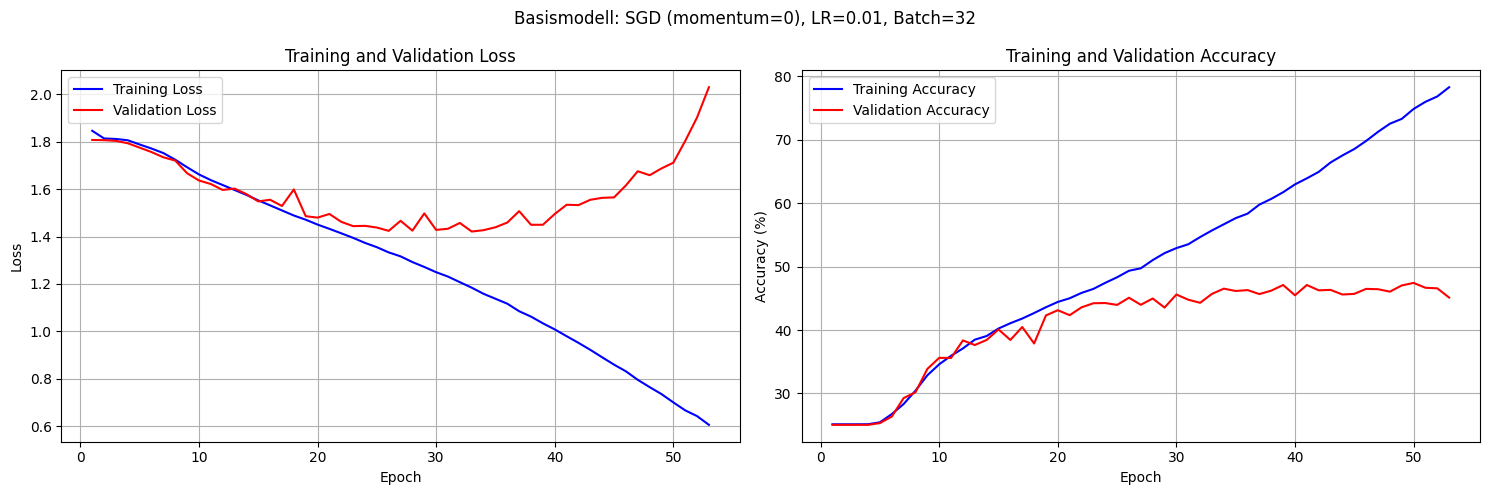

Lernkurven gespeichert als 'plots/baseline_training_curves.png'


In [5]:
# Lernkurven plotten und speichern
# Sicherstellen, dass plots Verzeichnis existiert
os.makedirs('plots', exist_ok=True)

fig = plot_training_curves(train_losses, val_losses, train_accs, val_accs, 
                          title="Basismodell: SGD (momentum=0), LR=0.01, Batch=32")

# Plot als Bild speichern
fig.savefig('plots/baseline_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()
print("Lernkurven gespeichert als 'plots/baseline_training_curves.png'")

### Hyperparameter-Tuning

**Ziel:** Vergleich verschiedener Lernraten und Batch-Größen anhand der Lernkurven und Metriken.

**Testkonfigurationen:**
- **Lernraten:** [0.001, 0.01, 0.1]
- **Batch-Größen:** [16, 32, 64]
- **Epochen:** 60 (konsistent mit Baseline-Training)
- **Optimizer:** SGD ohne Momentum

**Hinweis:** Bei kleinen Datasets wird das Training automatisch beschleunigt.


In [6]:
# Hyperparameter-Tuning mit wandb Integration
print("=== Hyperparameter-Tuning ===")

# Testkonfigurationen
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [16, 32, 64] 
num_epochs = 60  # Konsistent mit Baseline-Training (Epoche 60 als Referenz)

# Hyperparameter-Tuning mit wandb durchführen
# Modell-Klasse wird als Parameter übergeben 
results = hyperparameter_tuning_with_wandb(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    learning_rates=learning_rates,
    batch_sizes=batch_sizes,
    model_class=BaselineCNN,  # Modell-Klasse als Parameter
    num_epochs=num_epochs,
    img_size=img_size,
    num_classes=num_classes
)

# Finale Speicherbereinigung nach Hyperparameter-Tuning
if torch.cuda.is_available():
    torch.cuda.empty_cache()
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
gc.collect()
print("\n✓ Hyperparameter-Tuning abgeschlossen - Speicher freigegeben")


=== Hyperparameter-Tuning ===
=== Hyperparameter-Tuning mit wandb ===
Teste 3 Lernraten × 3 Batch-Größen = 9 Konfigurationen

--- LR_0.001_Batch_16 ---


Training startet: 60 Epochen, LR=0.001, Batch=16
Early Stopping: patience=8, min_delta=0.001
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.9072 | Val Loss: 1.8631 | Train Acc: 19.89% | Val Acc: 25.06% | Patience: 0/8


KeyboardInterrupt: 

Error in callback <bound method _WandbInit._post_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x124e63110>> (for post_run_cell), with arguments args (<ExecutionResult object at 1295ab950, execution_count=6 error_before_exec=None error_in_exec= info=<ExecutionInfo object at 1295ab850, raw_cell="# Hyperparameter-Tuning mit wandb Integration
prin.." transformed_cell="# Hyperparameter-Tuning mit wandb Integration
prin.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/Users/michellerohrer/Code/Deep_Learning/training.ipynb#X13sZmlsZQ%3D%3D> result=None>,),kwargs {}:


ConnectionResetError: Connection lost

In [ ]:
# Visualisierung der Hyperparameter-Ergebnisse
print("=== Hyperparameter-Vergleich ===")

# Zusammenfassung der Ergebnisse mit F1-Score und bester Performance
summary_data = []
for config_key, result in results.items():
    summary_data.append({
        'Learning Rate': result['learning_rate'],
        'Batch Size': result['batch_size'],
        'Final Train Acc (%)': result['final_train_acc'],
        'Final Val Acc (%)': result['final_val_acc'],
        'Best Val Acc (%)': result.get('best_val_acc', result['final_val_acc']),
        'Final Train F1': result.get('final_train_f1', 0),
        'Final Val F1': result.get('final_val_f1', 0),
        'Best Val F1': result.get('best_val_f1', result.get('final_val_f1', 0)),
        'Final Train Loss': result['final_train_loss'],
        'Final Val Loss': result['final_val_loss'],
        'Epochen': result.get('num_epochs', result.get('best_epoch', len(result.get('val_accs', []))))
    })

df_summary = pd.DataFrame(summary_data)
df_summary = df_summary.sort_values('Best Val Acc (%)', ascending=False)

print("Ergebnisse sortiert nach bester Validation Accuracy:")
print(df_summary[['Learning Rate', 'Batch Size', 'Best Val Acc (%)', 'Best Val F1', 'Final Val Acc (%)', 'Final Val F1', 'Epochen']].to_string(index=False))

# Beste Konfiguration finden
best_config = df_summary.iloc[0]
print(f"\nBeste Konfiguration:")
print(f"Learning Rate: {best_config['Learning Rate']}")
print(f"Batch Size: {best_config['Batch Size']}")
print(f"Beste Validation Accuracy: {best_config['Best Val Acc (%)']:.2f}% (Epoche {best_config['Epochen']})")
print(f"Beste Validation F1-Score: {best_config['Best Val F1']:.4f}")
print(f"Finale Validation Accuracy: {best_config['Final Val Acc (%)']:.2f}%")
print(f"Finale Validation F1-Score: {best_config['Final Val F1']:.4f}")


=== Hyperparameter-Vergleich ===
Ergebnisse sortiert nach Validation Accuracy:
 Learning Rate  Batch Size  Final Train Acc (%)  Final Val Acc (%)  Final Train Loss  Final Val Loss
         0.100          64            81.142509          51.375827          0.513771        1.880038
         0.010          16            76.683938          50.121909          0.637864        1.712376
         0.100          32            81.834806          49.111808          0.509277        1.873528
         0.010          32            64.880045          48.258447          0.953613        1.452223
         0.010          64            56.032568          47.648903          1.176764        1.399568
         0.100          16            72.913310          43.068617          0.740427        1.881738
         0.001          16            39.804938          39.167537          1.568298        1.568062
         0.001          32            29.342100          28.683386          1.739914        1.736720
         0.0

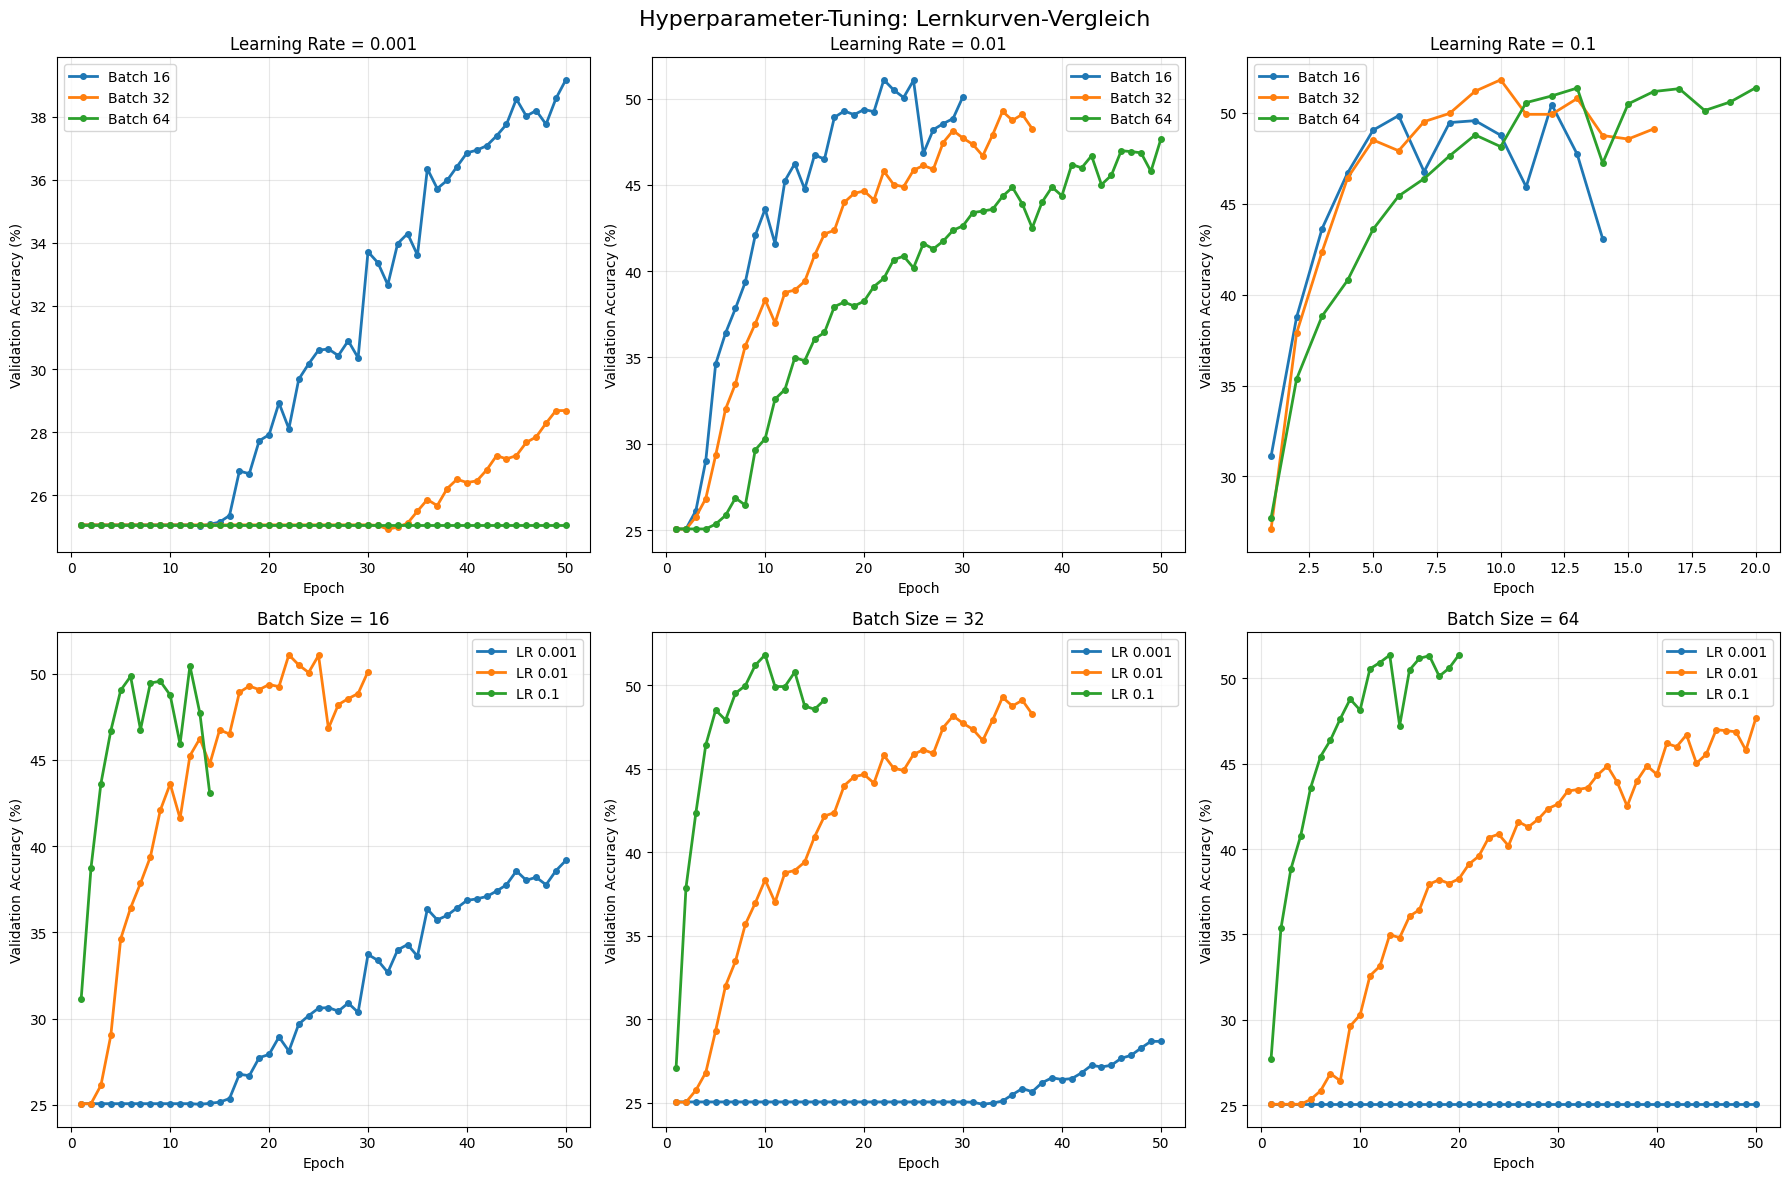

In [ ]:
# Lernkurven-Vergleich für verschiedene Konfigurationen (mit Trainingskurven)
# Sicherstellen, dass plots Verzeichnis existiert
os.makedirs('plots', exist_ok=True)

fig = plot_hyperparameter_comparison(
    results=results,
    learning_rates=learning_rates,
    batch_sizes=batch_sizes,
    save_path='plots/hyperparameter_comparison.png'
)

# Performance-Übersicht mit Accuracy, F1-Score, LR und Epochen
fig_perf = plot_hyperparameter_performance_summary(
    results=results,
    learning_rates=learning_rates,
    batch_sizes=batch_sizes,
    save_path='plots/hyperparameter_performance_summary.png'
)

print("Hyperparameter-Plots gespeichert:")
print("  - plots/hyperparameter_comparison.png")
print("  - plots/hyperparameter_performance_summary.png")


### Cross-Validation für statistische Fehlerschätzung

**Ziel:** Schätzung des statistischen Fehlers der Metriken durch Cross-Validation.

**Konfiguration:**
- **5-Fold Cross-Validation** auf dem Trainingsdatensatz
- **Beste Hyperparameter** aus dem Tuning verwenden
- **60 Epochen pro Fold** (konsistent mit Baseline-Training)
- **Early Stopping deaktiviert** für faire statistische Vergleichbarkeit
- **Statistische Auswertung:** Mittelwert ± Standardabweichung

**Hinweis zu Unsicherheiten:** Die Standardabweichung zeigt die Variabilität zwischen den Folds. 
Eine höhere Standardabweichung deutet auf größere Unsicherheit in den Ergebnissen hin, 
was durch unterschiedliche Datenverteilungen in den Folds oder Modell-Instabilität verursacht werden kann.


=== Cross-Validation ===
Verwende beste Konfiguration: LR=0.1, Batch=64
Cross-Validation mit 5 Folds

Fold 1/5
------------------------------
Training startet: 50 Epochen, LR=0.1, Batch=64
Early Stopping: patience=10, min_delta=0.001
------------------------------------------------------------
Epoch   1/50 | Train Loss: 1.8169 | Val Loss: 1.7949 | Train Acc: 24.85% | Val Acc: 25.46% | Patience: 0/10
Epoch   5/50 | Train Loss: 1.5335 | Val Loss: 1.4931 | Train Acc: 40.44% | Val Acc: 42.08% | Patience: 0/10
Epoch  10/50 | Train Loss: 1.2365 | Val Loss: 1.3387 | Train Acc: 53.21% | Val Acc: 48.94% | Patience: 0/10
Epoch  15/50 | Train Loss: 0.9337 | Val Loss: 1.4369 | Train Acc: 65.50% | Val Acc: 49.23% | Patience: 2/10
Epoch  20/50 | Train Loss: 0.5928 | Val Loss: 1.8138 | Train Acc: 78.51% | Val Acc: 48.50% | Patience: 7/10

Early Stopping nach 23 Epochen!
Beste Validation Loss: 1.3099 in Epoche 13

Fold 2/5
------------------------------
Training startet: 50 Epochen, LR=0.1, Batch=64
E

C:\Users\MichelleRohrer\AppData\Local\Temp\ipykernel_21424\121460383.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot(acc_data, labels=['Training', 'Validation'])
C:\Users\MichelleRohrer\AppData\Local\Temp\ipykernel_21424\121460383.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(loss_data, labels=['Training', 'Validation'])


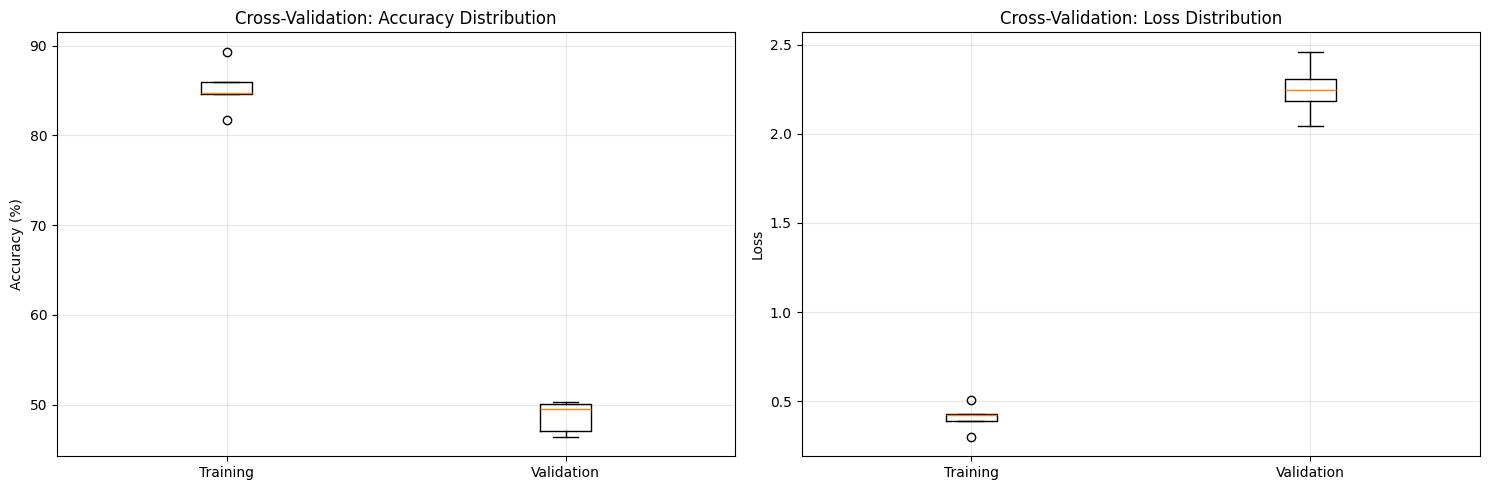

Cross-Validation Ergebnisse gespeichert als 'results/cross_validation_results.json'


In [ ]:
# Cross-Validation für statistische Fehlerschätzung
print("=== Cross-Validation ===")

# Beste Hyperparameter aus dem Tuning verwenden
best_lr = best_config['Learning Rate']
best_batch = int(best_config['Batch Size'])

print(f"Verwende beste Konfiguration: LR={best_lr}, Batch={best_batch}")
print(f"WICHTIG: Alle Folds trainieren exakt 60 Epochen (Early Stopping deaktiviert)")
print("Dies stellt sicher, dass die statistische Vergleichbarkeit gewährleistet ist.")

# Cross-Validation durchführen
# Modell-Klasse wird als Parameter übergeben, Early Stopping ist deaktiviert
cv_results = cross_validation_training(
    train_dataset=full_train_dataset,
    model_class=BaselineCNN,  # Modell-Klasse als Parameter
    num_folds=5,
    num_epochs=60,  # Konsistent mit Baseline-Training (Epoche 60 als Referenz)
    learning_rate=best_lr,
    batch_size=best_batch,
    img_size=img_size,
    num_classes=num_classes
)

print(f"\n=== Cross-Validation Ergebnisse (Mittelwert ± Standardabweichung) ===")
print(f"Training Accuracy: {cv_results['train_accuracies']['mean']:.4f} ± {cv_results['train_accuracies']['std']:.4f}")
print(f"Validation Accuracy: {cv_results['val_accuracies']['mean']:.4f} ± {cv_results['val_accuracies']['std']:.4f}")
print(f"Training Loss: {cv_results['train_losses']['mean']:.4f} ± {cv_results['train_losses']['std']:.4f}")
print(f"Validation Loss: {cv_results['val_losses']['mean']:.4f} ± {cv_results['val_losses']['std']:.4f}")

# F1-Scores ausgeben falls vorhanden
if 'train_f1s' in cv_results:
    print(f"Training F1-Score: {cv_results['train_f1s']['mean']:.4f} ± {cv_results['train_f1s']['std']:.4f}")
    print(f"Validation F1-Score: {cv_results['val_f1s']['mean']:.4f} ± {cv_results['val_f1s']['std']:.4f}")

print("\nInterpretation der Unsicherheiten:")
print("- Die Standardabweichung zeigt die Variabilität zwischen den 5 Folds.")
print("- Eine höhere Standardabweichung deutet auf größere Unsicherheit hin.")
print("- Mögliche Ursachen: Unterschiedliche Datenverteilungen in den Folds, Modell-Instabilität,")
print("  oder dass das Modell sehr empfindlich auf die Trainingsdaten reagiert.")

# Sicherstellen, dass das results Verzeichnis existiert
os.makedirs('results', exist_ok=True)

with open('results/cross_validation_results.json', 'w') as f:
    json.dump({
        'best_hyperparameters': {
            'learning_rate': best_lr,
            'batch_size': best_batch
        },
        'cv_results': cv_results,
        'num_epochs': 60,  # Dokumentation: Alle Folds trainierten 60 Epochen
        'note': 'Early Stopping wurde deaktiviert für konsistente Epochenanzahl'
    }, f, indent=2)

print("\nCross-Validation Ergebnisse gespeichert als 'results/cross_validation_results.json'")


## Hyperparameter-Experimente: Kategorie 1 - Modellkomplexität

**Hinweis:** Die Hypothesen, Erwartungen und Analysen sind im `main.ipynb` dokumentiert. Hier werden nur die Experimente durchgeführt.

**WICHTIG - Experimentdesign:**
Jedes Experiment variiert **nur EINEN Parameter** und hält alle anderen Parameter auf der Baseline-Konfiguration:
- **Baseline-Konfiguration:** 3 Conv-Layer, Filter [16, 32, 64], FC-Layer 64 Neuronen
- **Hypothese 1:** Variiert nur die Anzahl Conv-Layer (2, 3, 4, 5)
- **Hypothese 2:** Variiert nur die Filter-Anzahl pro Layer ([8,16,32], [16,32,64], [32,64,128], [64,128,256])
- **Hypothese 3:** Variiert nur die FC-Layer Breite (32, 64, 128, 256, 512 Neuronen)

Diese isolierte Variation ermöglicht es, den Effekt jedes einzelnen Parameters zu verstehen.

### Hypothese 1: Modelltiefe (Anzahl Conv-Layer)

**Variiert:** Nur die Anzahl Conv-Layer (2, 3, 4, 5)  
**Baseline-Parameter:** Filter [16, 32, 64], FC-Layer 64 Neuronen

In [ ]:
hypothesis_1_results = {}

# Experiment 1.1: Baseline (3 Layer) - Baseline-Konfiguration
print("\n" + "-"*60)
print("Experiment 1.1: Baseline (3 Conv-Layer)")
print("Filter: [16, 32, 64] (Baseline)")
print("FC-Layer: 64 Neuronen (Baseline)")
print("-"*60)

result_3 = run_hyperparameter_experiment(
    experiment_name="hyp1_baseline_3layers",
    model_class=FlexibleCNN,
    model_kwargs={
        'img_size': img_size,
        'num_classes': num_classes,
        'num_conv_layers': 3,
        'filters_per_layer': [16, 32, 64]  
    },
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=60,
    learning_rate=0.01,  
    batch_size=32, 
    device=device,
    use_wandb=True
)
hypothesis_1_results['3_layers'] = result_3

# Speicherbereinigung nach Experiment
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
gc.collect()

In [ ]:
# Experiment 1.2: 2 Layer
print("\n" + "-"*60)
print("Experiment 1.2: 2 Conv-Layer")
print("Filter: [16, 32]")
print("FC-Layer: 64 Neuronen (Baseline)")
print("-"*60)

result_2 = run_hyperparameter_experiment(
    experiment_name="hyp1_2layers",
    model_class=FlexibleCNN,
    model_kwargs={
        'img_size': img_size,
        'num_classes': num_classes,
        'num_conv_layers': 2,  
        'filters_per_layer': [16, 32]  
    },
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=60,
    learning_rate=0.01,  
    batch_size=32, 
    device=device,
    use_wandb=True
)
hypothesis_1_results['2_layers'] = result_2

# Speicherbereinigung nach Experiment
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
gc.collect()

In [ ]:
# Experiment 1.3: 4 Layer
print("\n" + "-"*60)
print("Experiment 1.3: 4 Conv-Layer")
print("Filter: [16, 32, 64, 128]")
print("FC-Layer: 64 Neuronen (Baseline)")
print("-"*60)

result_4 = run_hyperparameter_experiment(
    experiment_name="hyp1_4layers",
    model_class=FlexibleCNN,
    model_kwargs={
        'img_size': img_size,
        'num_classes': num_classes,
        'num_conv_layers': 4, 
        'filters_per_layer': [16, 32, 64, 128] 
    },
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=60,
    learning_rate=0.01,  
    batch_size=32, 
    device=device,
    use_wandb=True
)
hypothesis_1_results['4_layers'] = result_4

# Speicherbereinigung nach Experiment
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
gc.collect()

In [ ]:
# Experiment 1.4: 5 Layer 
print("\n" + "-"*60)
print("Experiment 1.4: 5 Conv-Layer")
print("Filter: [16, 32, 64, 128, 256]")
print("FC-Layer: 64 Neuronen (Baseline)")
print("-"*60)

result_5 = run_hyperparameter_experiment(
    experiment_name="hyp1_5layers",
    model_class=FlexibleCNN,
    model_kwargs={
        'img_size': img_size,
        'num_classes': num_classes,
        'num_conv_layers': 5,  # Variiert
        'filters_per_layer': [16, 32, 64, 128, 256] 
    },
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=60,
    learning_rate=0.01,  
    batch_size=32,  
    device=device,
    use_wandb=True
)
hypothesis_1_results['5_layers'] = result_5

# Speicherbereinigung nach Experiment
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
gc.collect()

In [ ]:
# Analyse und Visualisierung Hypothese 1
print("\n" + "="*80)
print("ANALYSE HYPOTHESE 1: MODELLTIEFE")
print("="*80)

# Zusammenfassungstabelle
summary_data = []
for name, result in hypothesis_1_results.items():
    summary_data.append({
        'Konfiguration': name,
        'Parameter': f"{result['num_params']:,}",
        'Beste Val Acc (%)': f"{result['best_val_acc']:.2f}",
        'Finale Val Acc (%)': f"{result['final_val_acc']:.2f}",
        'Finale Val F1': f"{result['final_val_f1']:.4f}",
        'Overfitting-Gap (%)': f"{result['overfitting_gap_acc']:.2f}",
        'Beste Epoche': result['best_epoch']
    })

df_summary = pd.DataFrame(summary_data)
print("\nZusammenfassung der Ergebnisse:")
print(df_summary.to_string(index=False))

# Visualisierung
os.makedirs('plots/experiments', exist_ok=True)

fig = plot_experiment_comparison(hypothesis_1_results, metric='val_acc', 
                                 title='Hypothese 1: Modelltiefe - Validation Accuracy')
plt.savefig('plots/experiments/hyp1_depth_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

fig = plot_model_complexity_analysis(hypothesis_1_results, complexity_metric='num_params')
plt.savefig('plots/experiments/hyp1_complexity_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

fig = plot_training_curves_comparison(hypothesis_1_results, 
                                     title='Hypothese 1: Modelltiefe - Trainingskurven')
plt.savefig('plots/experiments/hyp1_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Ergebnisse speichern
save_experiment_results(hypothesis_1_results, 'results/hypothesis_1_depth.json')
print("\nErgebnisse gespeichert: results/hypothesis_1_depth.json")

### Hypothese 2: Modellbreite (Filter-Anzahl)

**Variiert:** Nur die Filter-Anzahl pro Layer ([8, 16, 32], [16, 32, 64], [32, 64, 128], [64, 128, 256])  
**Konstant:** 3 Conv-Layer (Baseline), FC-Layer 64 Neuronen (Baseline)

In [ ]:
hypothesis_2_results = {}

# Experiment 2.1: Baseline [16, 32, 64]
print("\n" + "-"*60)
print("Experiment 2.1: Baseline [16, 32, 64] Filter")
print("-"*60)

result_baseline = run_hyperparameter_experiment(
    experiment_name="hyp2_baseline_16_32_64",
    model_class=FlexibleCNN,
    model_kwargs={
        'img_size': img_size,
        'num_classes': num_classes,
        'num_conv_layers': 3, 
        'filters_per_layer': [16, 32, 64] 
    },
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=60,
    learning_rate=0.01, 
    batch_size=32, 
    device=device,
    use_wandb=True
)
hypothesis_2_results['16_32_64'] = result_baseline

# Speicherbereinigung nach Experiment
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
gc.collect()

In [ ]:
# Experiment 2.2: [8, 16, 32] Filter 
print("\n" + "-"*60)
print("Experiment 2.2: [8, 16, 32] Filter")
print("-"*60)

result_narrow = run_hyperparameter_experiment(
    experiment_name="hyp2_narrow_8_16_32",
    model_class=FlexibleCNN,
    model_kwargs={
        'img_size': img_size,
        'num_classes': num_classes,
        'num_conv_layers': 3, 
        'filters_per_layer': [8, 16, 32] 
    },
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=60,
    learning_rate=0.01,  
    batch_size=32,  
    device=device,
    use_wandb=True
)
hypothesis_2_results['8_16_32'] = result_narrow

# Speicherbereinigung nach Experiment
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
gc.collect()

In [ ]:
# Experiment 2.3: [32, 64, 128] Filter 
print("\n" + "-"*60)
print("Experiment 2.3: [32, 64, 128] Filter")
print("-"*60)

result_wide1 = run_hyperparameter_experiment(
    experiment_name="hyp2_wide_32_64_128",
    model_class=FlexibleCNN,
    model_kwargs={
        'img_size': img_size,
        'num_classes': num_classes,
        'num_conv_layers': 3,  
        'filters_per_layer': [32, 64, 128]  
    },
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=60,
    learning_rate=0.01, 
    batch_size=32, 
    device=device,
    use_wandb=True
)
hypothesis_2_results['32_64_128'] = result_wide1

# Speicherbereinigung nach Experiment
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
gc.collect()

In [ ]:
# Experiment 2.4: [64, 128, 256] Filter 
print("\n" + "-"*60)
print("Experiment 2.4: [64, 128, 256] Filter")
print("-"*60)

result_wide2 = run_hyperparameter_experiment(
    experiment_name="hyp2_very_wide_64_128_256",
    model_class=FlexibleCNN,
    model_kwargs={
        'img_size': img_size,
        'num_classes': num_classes,
        'num_conv_layers': 3, 
        'filters_per_layer': [64, 128, 256]  
    },
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=60,
    learning_rate=0.01, 
    batch_size=32, 
    device=device,
    use_wandb=True
)
hypothesis_2_results['64_128_256'] = result_wide2

# Speicherbereinigung nach Experiment
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
gc.collect()

In [ ]:
# Analyse und Visualisierung Hypothese 2
print("\n" + "="*80)
print("ANALYSE HYPOTHESE 2: MODELLBREITE")
print("="*80)

summary_data = []
for name, result in hypothesis_2_results.items():
    summary_data.append({
        'Konfiguration': name,
        'Parameter': f"{result['num_params']:,}",
        'Beste Val Acc (%)': f"{result['best_val_acc']:.2f}",
        'Finale Val Acc (%)': f"{result['final_val_acc']:.2f}",
        'Overfitting-Gap (%)': f"{result['overfitting_gap_acc']:.2f}"
    })

df_summary = pd.DataFrame(summary_data)
print("\nZusammenfassung der Ergebnisse:")
print(df_summary.to_string(index=False))

# Visualisierung
fig = plot_experiment_comparison(hypothesis_2_results, metric='val_acc', 
                                 title='Hypothese 2: Modellbreite - Validation Accuracy')
plt.savefig('plots/experiments/hyp2_width_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

fig = plot_model_complexity_analysis(hypothesis_2_results, complexity_metric='num_params')
plt.savefig('plots/experiments/hyp2_complexity_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

fig = plot_training_curves_comparison(hypothesis_2_results, 
                                     title='Hypothese 2: Modellbreite - Trainingskurven')
plt.savefig('plots/experiments/hyp2_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Ergebnisse speichern
save_experiment_results(hypothesis_2_results, 'results/hypothesis_2_width.json')
print("\nErgebnisse gespeichert: results/hypothesis_2_width.json")

### Hypothese 3: FC-Layer Breite (Anzahl Neuronen)

**Variiert:** Nur die FC-Layer Breite (32, 64, 128, 256, 512 Neuronen)  
**Konstant:** 3 Conv-Layer (Baseline), Filter [16, 32, 64] (Baseline)

In [ ]:
hypothesis_3_results = {}

# Experiment 3.1: Baseline 64 Neuronen 
print("\n" + "-"*60)
print("Experiment 3.1: Baseline 64 Neuronen")
print("Conv-Layer: 3 (Baseline)")
print("Filter: [16, 32, 64] (Baseline)")
print("-"*60)

result_64 = run_hyperparameter_experiment(
    experiment_name="hyp3_baseline_64",
    model_class=FlexibleCNN,
    model_kwargs={
        'img_size': img_size,
        'num_classes': num_classes,
        'num_conv_layers': 3, 
        'filters_per_layer': [16, 32, 64], 
        'fc_units': 64 
    },
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=60,
    learning_rate=0.01, 
    batch_size=32, 
    device=device,
    use_wandb=True
)
hypothesis_3_results['64_units'] = result_64

# Speicherbereinigung nach Experiment
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
gc.collect()

In [ ]:
# Experiment 3.2: 32 Neuronen 
print("\n" + "-"*60)
print("Experiment 3.2: 32 Neuronen")
print("Conv-Layer: 3 (Baseline)")
print("Filter: [16, 32, 64] (Baseline)")
print("-"*60)

result_32 = run_hyperparameter_experiment(
    experiment_name="hyp3_32_units",
    model_class=FlexibleCNN,
    model_kwargs={
        'img_size': img_size,
        'num_classes': num_classes,
        'num_conv_layers': 3,  
        'filters_per_layer': [16, 32, 64], 
        'fc_units': 32  
    },
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=60,
    learning_rate=0.01, 
    batch_size=32, 
    device=device,
    use_wandb=True
)
hypothesis_3_results['32_units'] = result_32

# Speicherbereinigung nach Experiment
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
gc.collect()

In [ ]:
# Experiment 3.3: 128 Neuronen 
print("\n" + "-"*60)
print("Experiment 3.3: 128 Neuronen")
print("Conv-Layer: 3 (Baseline)")
print("Filter: [16, 32, 64] (Baseline)")
print("-"*60)

result_128 = run_hyperparameter_experiment(
    experiment_name="hyp3_128_units",
    model_class=FlexibleCNN,
    model_kwargs={
        'img_size': img_size,
        'num_classes': num_classes,
        'num_conv_layers': 3,  
        'filters_per_layer': [16, 32, 64], 
        'fc_units': 128  
    },
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=60,
    learning_rate=0.01, 
    batch_size=32,  
    device=device,
    use_wandb=True
)
hypothesis_3_results['128_units'] = result_128

# Speicherbereinigung nach Experiment
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
gc.collect()

In [ ]:
# Experiment 3.4: 256 Neuronen
print("\n" + "-"*60)
print("Experiment 3.4: 256 Neuronen")
print("Conv-Layer: 3 (Baseline)")
print("Filter: [16, 32, 64] (Baseline)")
print("-"*60)

result_256 = run_hyperparameter_experiment(
    experiment_name="hyp3_256_units",
    model_class=FlexibleCNN,
    model_kwargs={
        'img_size': img_size,
        'num_classes': num_classes,
        'num_conv_layers': 3, 
        'filters_per_layer': [16, 32, 64],
        'fc_units': 256  
    },
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=60,
    learning_rate=0.01, 
    batch_size=32, 
    device=device,
    use_wandb=True
)
hypothesis_3_results['256_units'] = result_256

# Speicherbereinigung nach Experiment
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
gc.collect()

In [ ]:
# Experiment 3.5: 512 Neuronen - nur FC-Layer Breite variiert
print("\n" + "-"*60)
print("Experiment 3.5: 512 Neuronen")
print("Conv-Layer: 3 (Baseline)")
print("Filter: [16, 32, 64] (Baseline)")
print("-"*60)

result_512 = run_hyperparameter_experiment(
    experiment_name="hyp3_512_units",
    model_class=FlexibleCNN,
    model_kwargs={
        'img_size': img_size,
        'num_classes': num_classes,
        'num_conv_layers': 3,
        'filters_per_layer': [16, 32, 64], 
        'fc_units': 512  
    },
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=60,
    learning_rate=0.01, 
    batch_size=32, 
    device=device,
    use_wandb=True
)
hypothesis_3_results['512_units'] = result_512

# Speicherbereinigung nach Experiment
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
gc.collect()

In [ ]:
# Analyse und Visualisierung Hypothese 3
print("\n" + "="*80)
print("ANALYSE HYPOTHESE 3: FC-LAYER BREITE")
print("="*80)

summary_data = []
for name, result in hypothesis_3_results.items():
    summary_data.append({
        'Konfiguration': name,
        'Parameter': f"{result['num_params']:,}",
        'Beste Val Acc (%)': f"{result['best_val_acc']:.2f}",
        'Finale Val Acc (%)': f"{result['final_val_acc']:.2f}",
        'Overfitting-Gap (%)': f"{result['overfitting_gap_acc']:.2f}"
    })

df_summary = pd.DataFrame(summary_data)
print("\nZusammenfassung der Ergebnisse:")
print(df_summary.to_string(index=False))

# Visualisierung
fig = plot_experiment_comparison(hypothesis_3_results, metric='val_acc', 
                                 title='Hypothese 3: FC-Layer Breite - Validation Accuracy')
plt.savefig('plots/experiments/hyp3_fc_width_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

fig = plot_model_complexity_analysis(hypothesis_3_results, complexity_metric='num_params')
plt.savefig('plots/experiments/hyp3_complexity_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

fig = plot_training_curves_comparison(hypothesis_3_results, 
                                     title='Hypothese 3: FC-Layer Breite - Trainingskurven')
plt.savefig('plots/experiments/hyp3_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Ergebnisse speichern
save_experiment_results(hypothesis_3_results, 'results/hypothesis_3_fc_width.json')
print("\nErgebnisse gespeichert: results/hypothesis_3_fc_width.json")

### Zusammenfassung Kategorie 1

In [ ]:
# Zusammenfassung aller Experimente
print("="*80)
print("ZUSAMMENFASSUNG: KATEGORIE 1 - MODELLKOMPLEXITÄT")
print("="*80)

# Beste Konfigurationen aus jeder Hypothese
best_hyp1 = max(hypothesis_1_results.keys(), 
                key=lambda k: hypothesis_1_results[k]['best_val_acc'])
best_hyp2 = max(hypothesis_2_results.keys(), 
                key=lambda k: hypothesis_2_results[k]['best_val_acc'])
best_hyp3 = max(hypothesis_3_results.keys(), 
                key=lambda k: hypothesis_3_results[k]['best_val_acc'])

summary_all = {
    'Hyp1_Best': hypothesis_1_results[best_hyp1],
    'Hyp2_Best': hypothesis_2_results[best_hyp2],
    'Hyp3_Best': hypothesis_3_results[best_hyp3]
}

# Vergleichstabelle
comparison_data = []
for name, result in summary_all.items():
    comparison_data.append({
        'Hypothese': name,
        'Konfiguration': result['experiment_name'],
        'Parameter': f"{result['num_params']:,}",
        'Beste Val Acc (%)': f"{result['best_val_acc']:.2f}",
        'Finale Val Acc (%)': f"{result['final_val_acc']:.2f}",
        'Overfitting-Gap (%)': f"{result['overfitting_gap_acc']:.2f}"
    })

df_comparison = pd.DataFrame(comparison_data)
print("\nBeste Konfigurationen pro Hypothese:")
print(df_comparison.to_string(index=False))

# Gesamtbeste Konfiguration
overall_best = max(summary_all.keys(), 
                  key=lambda k: summary_all[k]['best_val_acc'])
overall_best_result = summary_all[overall_best]

print(f"\n{'='*80}")
print(f"GESAMTBESTE KONFIGURATION: {overall_best}")
print(f"{'='*80}")
print(f"Experiment: {overall_best_result['experiment_name']}")
print(f"Beste Validation Accuracy: {overall_best_result['best_val_acc']:.2f}%")
print(f"Finale Validation Accuracy: {overall_best_result['final_val_acc']:.2f}%")
print(f"Overfitting-Gap: {overall_best_result['overfitting_gap_acc']:.2f}%")
print(f"Modell-Parameter: {overall_best_result['num_params']:,}")

# Visualisierung aller besten Konfigurationen
fig = plot_experiment_comparison(summary_all, metric='val_acc', 
                                 title='Kategorie 1: Beste Konfigurationen - Vergleich')
plt.savefig('plots/experiments/category1_best_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Alle Ergebnisse speichern
all_results = {
    'hypothesis_1': hypothesis_1_results,
    'hypothesis_2': hypothesis_2_results,
    'hypothesis_3': hypothesis_3_results,
    'summary': {
        'best_hyp1': best_hyp1,
        'best_hyp2': best_hyp2,
        'best_hyp3': best_hyp3,
        'overall_best': overall_best
    }
}

save_experiment_results(all_results, 'results/category1_all_results.json')
print("\nAlle Ergebnisse gespeichert: results/category1_all_results.json")